In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [0]:
PATH = 'drive/My Drive/Data_Merged.csv'

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [0]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0

In [0]:
def split(dataset,horizon,feature_num):
  return dataset[:, :-horizon*feature_num], dataset[:, -horizon*feature_num:]

In [0]:
def prepareDataset(HORIZON,WINDOW_SIZE):
  data={}
  # load dataset
  dataset = read_csv(PATH, header=0, index_col=0)
  feature_num = dataset.shape[1]
  data['feature_num'] = feature_num
  values = dataset.values.reshape(-1,feature_num)
  # ensure all data is float
  values = values.astype('float32')
  # frame as supervised learning
  reframed = series_to_supervised(values,WINDOW_SIZE,HORIZON)
  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(reframed)
  data['scaler'] = scaler
  # split data into train, validation and test sets
  train_size=int(len(scaled)*0.7)
  val_size=int(len(scaled)*0.2)
  test_size=int(len(scaled)*0.1)
  trainset = scaled[:train_size, :]
  valset = scaled[train_size:train_size+val_size, :]
  testset = scaled[-test_size:, :]
  # split data into inputs and outputs
  train_X, data['train_y'] = split(trainset,HORIZON,feature_num)
  val_X, data['val_y'] = split(valset,HORIZON,feature_num)
  test_X, data['test_y'] = split(testset,HORIZON,feature_num)
  # reshape input to be 3D [#samples, #timesteps, #features]
  data['train_X'] = train_X.reshape(train_X.shape[0], WINDOW_SIZE, feature_num)
  data['val_X'] = val_X.reshape(val_X.shape[0], WINDOW_SIZE, feature_num)
  data['test_X'] = test_X.reshape(test_X.shape[0], WINDOW_SIZE, feature_num)  
  return data

In [0]:
def model_LSTM(train_X,HORIZON,feature_num):
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(HORIZON*feature_num))
  model.compile(loss='mse', optimizer='adam')
  return model


# fit network
def fit_model(HORIZON,feature_num,train_X, train_y,val_X, val_y):
  model=model_LSTM(train_X,HORIZON,feature_num)
  history = model.fit(train_X, train_y, epochs = 30, batch_size=64, validation_data=(val_X, val_y), verbose=0, shuffle=False)
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='val')
  plt.legend()
  plt.show()
  return model

In [0]:
def get_acc(predict,true):
  avg_acc = []
  for i in range(len(predict)):
    acc = 1- abs((predict[i]-true[i])/true[i])
    avg_acc.append(acc)
  return sum(avg_acc)/len(predict)

In [0]:
def evaluate_model(model,test_X,test_y,feature_num,scaler):
  predict = model.predict(test_X)
  inv_test_X = test_X.reshape(test_X.shape[0],test_X.shape[1]*test_X.shape[2])
  # invert scaling for forecast
  con_pre = concatenate((predict,inv_test_X), axis=1)
  inv_predict = scaler.inverse_transform(con_pre)
  predict = inv_predict[:,feature_num-1]
  # invert scaling for actual
  con_true = concatenate((test_y,inv_test_X), axis=1)
  inv_true = scaler.inverse_transform(con_true)
  true = inv_true[:,feature_num-1]
  # evaluate the model
  rmse = sqrt(mean_squared_error(true, predict))
  print('Test RMSE: %.3f' % rmse)
  acc = get_acc(predict,true)
  print('Test accuracy: %.3f' % acc)
  # plot the prediction and true line
  plt.plot(true, label='true')
  plt.plot(predict, label='predict')
  plt.legend()
  plt.show()
  return acc

---------------------------------------------------------------------------------------
HORIZON: 1 WINDOW_SIZE: 1




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



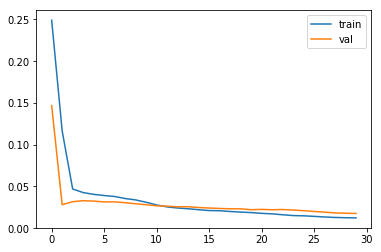

Test RMSE: 107.753
Test accuracy: 0.872


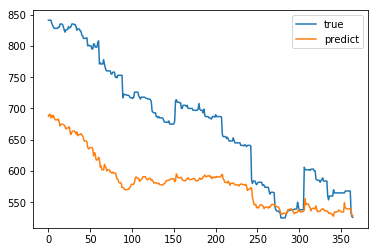

---------------------------------------------------------------------------------------
HORIZON: 1 WINDOW_SIZE: 10


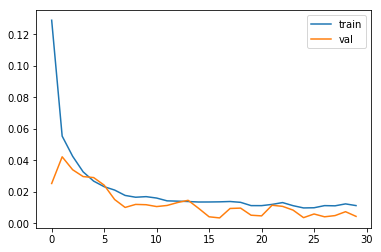

Test RMSE: 60.904
Test accuracy: 0.925


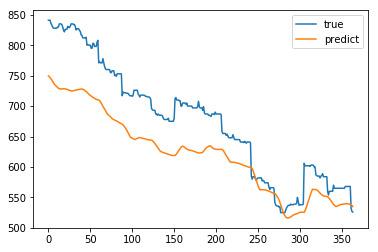

---------------------------------------------------------------------------------------
HORIZON: 1 WINDOW_SIZE: 30


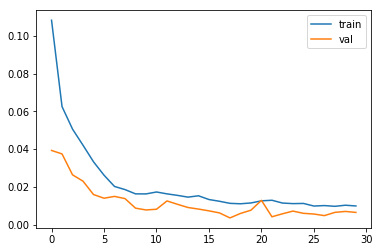

Test RMSE: 39.077
Test accuracy: 0.956


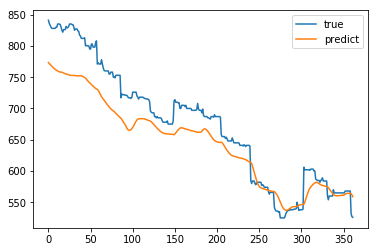

---------------------------------------------------------------------------------------
HORIZON: 7 WINDOW_SIZE: 1


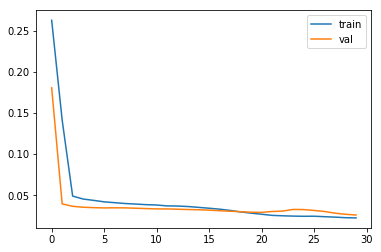

Test RMSE: 119.246
Test accuracy: 0.862


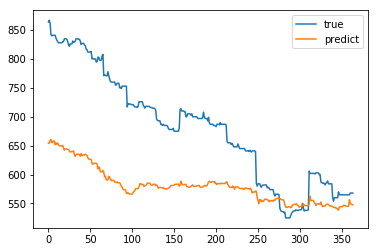

---------------------------------------------------------------------------------------
HORIZON: 7 WINDOW_SIZE: 10


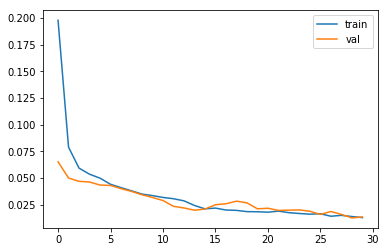

Test RMSE: 91.744
Test accuracy: 0.894


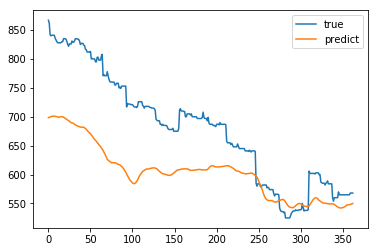

---------------------------------------------------------------------------------------
HORIZON: 7 WINDOW_SIZE: 30


In [0]:
def compareHyperPram(HORIZON,WINDOW_SIZE):
  # Calculate the accuracy for each model
  result = []
  for h in HORIZON:
    result_h = []
    for w in WINDOW_SIZE:
      print("---------------------------------------------------------------------------------------")
      print("HORIZON: %d WINDOW_SIZE: %d"%(h,w))
      data = prepareDataset(h,w)
      feature_num = data['feature_num']
      scaler = data['scaler']
      model = fit_model(h,feature_num,data['train_X'], data['train_y'],data['val_X'], data['val_y'])
      acc = evaluate_model(model,data['test_X'],data['test_y'],feature_num,scaler)
      result_h.append(acc)
    result.append(result_h)
  return result

HORIZON = [1,7,30,90,365]
WINDOW_SIZE = [1,10,30]
result = compareHyperPram(HORIZON,WINDOW_SIZE)

In [0]:
from matplotlib import cm
color = cm.get_cmap('tab20c') 
for i in range(len(WINDOW_SIZE)):
  for j in range(len(HORIZON)):
    if j==0:
      label="Window Size of "+ str(WINDOW_SIZE[i])
      plt.scatter(HORIZON[j],result[j][i],color=color(i),label=label)
    plt.scatter(HORIZON[j],result[j][i],color=color(i))
plt.xlabel("Horizon")
plt.ylabel("Acuracy")
plt.title("Comparing Peformance with Different Horizons and Window Sizes")
plt.legend()
plt.show()